# Practical Statistics for Data Scientists (R)
# Chapter 6. Statistical Machine Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required R packages.

In [1]:
library(dplyr)
library(ggplot2)
library(FNN)
library(rpart)
library(randomForest)
library(xgboost)

Warning message:
“package ‘dplyr’ was built under R version 4.1.2”



Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Warning message:
“package ‘rpart’ was built under R version 4.1.2”


randomForest 4.6-14



Type rfNews() to see new features/changes/bug fixes.




Attaching package: ‘randomForest’




The following object is masked from ‘package:ggplot2’:

    margin




The following object is masked from ‘package:dplyr’:

    combine





Attaching package: ‘xgboost’




The following object is masked from ‘package:dplyr’:

    slice




Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
PSDS_PATH <- file.path(dirname(dirname(getwd())))

loan200 <- read.csv(file.path(PSDS_PATH, 'data', 'loan200.csv'), stringsAsFactors=TRUE)
loan200$outcome <- ordered(loan200$outcome, levels=c('paid off', 'default'))

loan3000 <- read.csv(file.path(PSDS_PATH, 'data', 'loan3000.csv'), stringsAsFactors=TRUE)
loan3000$outcome <- ordered(loan3000$outcome, levels=c('paid off', 'default'))

loan_data <- read.csv(file.path(PSDS_PATH, 'data', 'loan_data.csv.gz'), stringsAsFactors=TRUE)
loan_data <- dplyr::select(loan_data, -X, -status)
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))

In [3]:
# Set this if XGBoost returns training errors of 0
Sys.setenv(KMP_DUPLICATE_LIB_OK = "TRUE")

# K-Nearest Neighbors
## A Small Example: Predicting Loan Default

In [4]:
newloan <- loan200[1, 2:3, drop=FALSE]
knn_pred <- knn(train=loan200[-1, 2:3], test=newloan, cl=loan200[-1, 1], k=20)
knn_pred == 'paid off'

[1] TRUE

In [5]:
## look at the nearest 20 records and create circle
# we add 1 as we excluded the first data point for prediction
nearest_points <- loan200[attr(knn_pred, 'nn.index') + 1, ] 
nearest_points
dist <- attr(knn_pred, 'nn.dist')

circleFun <- function(center=c(0, 0), r=1, npoints=100){
  tt <- seq(0, 2 * pi, length.out=npoints - 1)
  xx <- center[1] + r * cos(tt)
  yy <- center[2] + r * sin(tt)
  return(data.frame(x=c(xx, xx[1]), y=c(yy, yy[1])))
}

circle_df <- circleFun(center=unlist(newloan), r=max(dist), npoints=201)

loan200_df <- loan200 # bind_cols(loan200, circle_df)
levels(loan200_df$outcome)

,outcome,payment_inc_ratio,dti
,<ord>,<dbl>,<dbl>
36,default,8.65527,22.23
183,default,9.05778,21.62
182,paid off,9.44925,23.30
86,default,8.70942,24.13
10,default,9.43396,24.15
170,default,8.02887,20.86
22,default,6.91886,22.47
200,paid off,9.64200,20.17
78,paid off,7.70160,24.57


[1] "paid off" "default"

In [6]:
# set first entry as target - requires adding additional level to factor
levels(loan200_df$outcome) <- c(levels(loan200_df$outcome), "newloan")
loan200_df[1, 'outcome'] <- 'newloan'
head(loan200_df)
levels(nearest_points$outcome) <- levels(loan200_df$outcome)

,outcome,payment_inc_ratio,dti
,<ord>,<dbl>,<dbl>
1,newloan,9.00000,22.50
2,default,5.46933,21.33
3,paid off,6.90294,8.97
4,paid off,11.14800,1.83
5,default,3.72120,10.81
6,paid off,1.89923,11.34


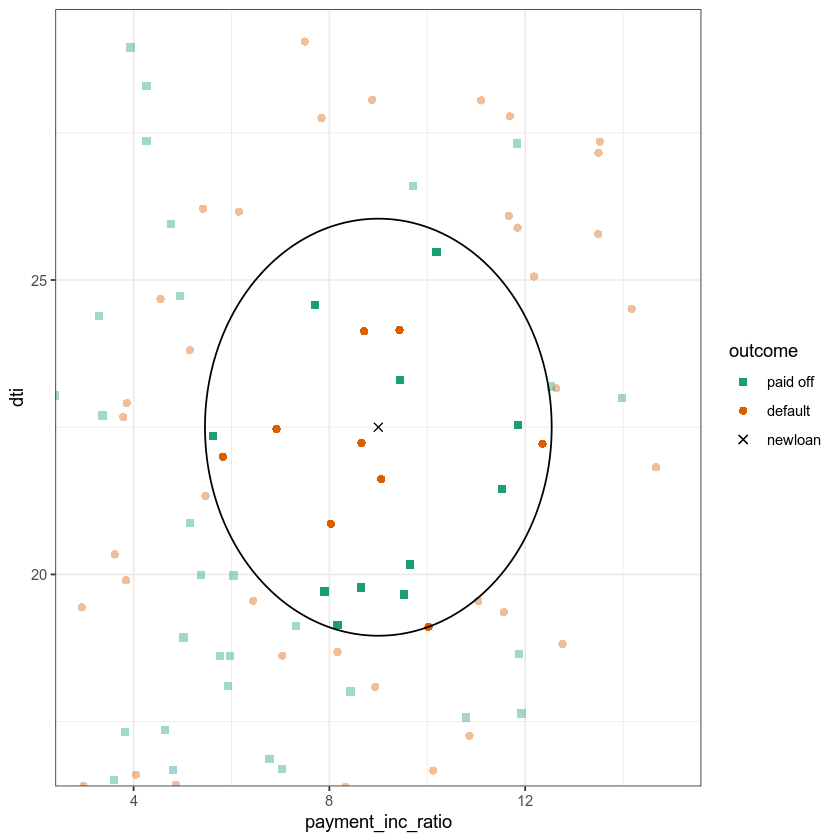

In [7]:
graph <- ggplot(data=loan200_df, aes(x=payment_inc_ratio, y=dti, color=outcome)) + # , shape=outcome)) +
  geom_point(aes(shape=outcome), size=2, alpha=0.4) +
  geom_point(data=nearest_points, aes(shape=outcome), size=2) +
  geom_point(data=loan200_df[1,], aes(shape=outcome), size=2) +
  scale_shape_manual(values=c(15, 16, 4)) +
  scale_color_manual(values = c("paid off"="#1b9e77", "default"="#d95f02", "newloan"='black')) +
  geom_path(data=circle_df, aes(x=x, y=y), color='black') +
  coord_cartesian(xlim=c(3, 15), ylim=c(17, 29)) +
  theme_bw() 
graph

## Standardization (Normalization, Z-Scores)

In [8]:
loan_df <- model.matrix(~ -1 + payment_inc_ratio + dti + revol_bal + 
                          revol_util, data=loan_data)
newloan <- loan_df[1, , drop=FALSE]
loan_df <- loan_df[-1,]
outcome <- loan_data[-1, 1]
knn_pred <- knn(train=loan_df, test=newloan, cl=outcome, k=5)
loan_df[attr(knn_pred, "nn.index"),]

,payment_inc_ratio,dti,revol_bal,revol_util
35537,1.47212,1.46,1686,10.0
33652,3.38178,6.37,1688,8.4
25864,2.36303,1.39,1691,3.5
42954,1.28160,7.14,1684,3.9
43600,4.12244,8.98,1684,7.2


In [9]:
loan_df <- model.matrix(~ -1 + payment_inc_ratio + dti + revol_bal + 
                          revol_util, data=loan_data)
loan_std <- scale(loan_df)
newloan_std <- loan_std[1, , drop=FALSE]
loan_std <- loan_std[-1,]
loan_df <- loan_df[-1,]
outcome <- loan_data[-1, 1]
knn_pred <- knn(train=loan_std, test=newloan_std, cl=outcome, k=5)
loan_df[attr(knn_pred, "nn.index"),]

,payment_inc_ratio,dti,revol_bal,revol_util
2081,2.61091,1.03,1218,9.7
1439,2.34343,0.51,278,9.9
30216,2.71200,1.34,1075,8.5
28543,2.39760,0.74,2917,7.4
44738,2.34309,1.37,488,7.2


## KNN as a Feature Engine

In [10]:
borrow_df <- model.matrix(~ -1 + dti + revol_bal + revol_util + open_acc +
                            delinq_2yrs_zero + pub_rec_zero, data=loan_data)
borrow_knn <- knn(borrow_df, test=borrow_df, cl=loan_data[, 'outcome'], prob=TRUE, k=20)
prob <- attr(borrow_knn, "prob")
borrow_feature <- ifelse(borrow_knn == 'default', prob, 1 - prob)
summary(borrow_feature)

loan_data$borrower_score <- borrow_feature

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.400   0.500   0.501   0.600   0.950 

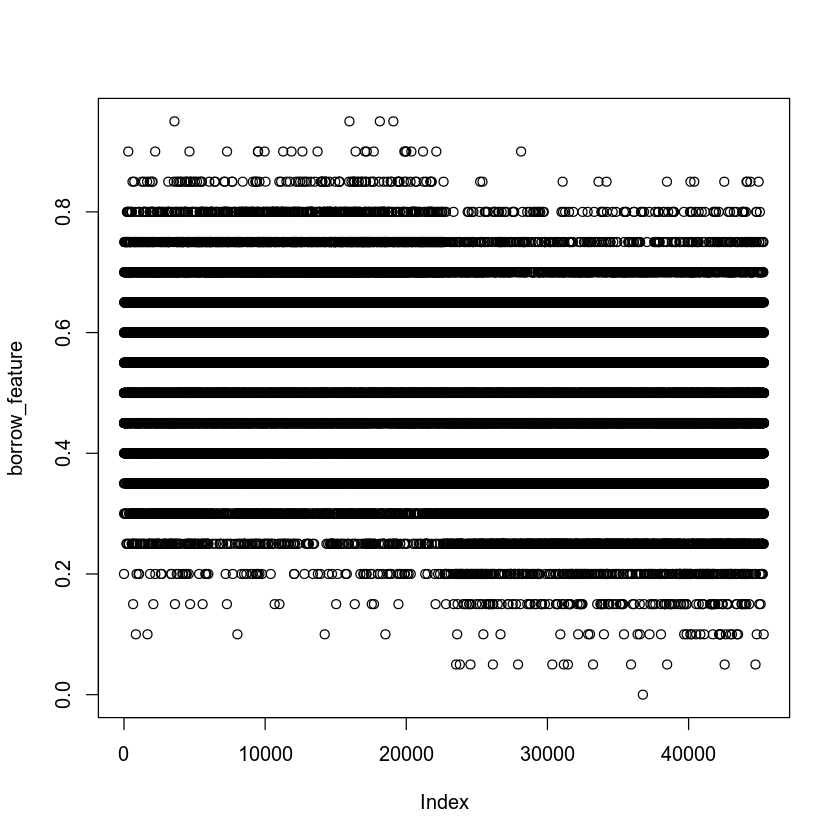

In [11]:
plot(borrow_feature)

# Tree Models
## A Simple Example

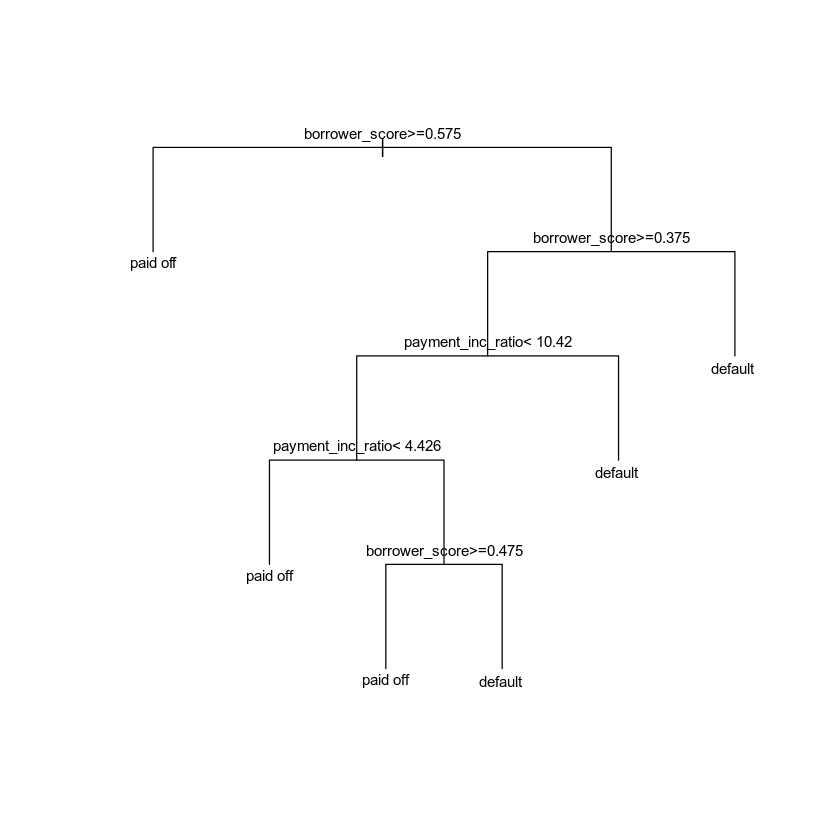

In [12]:
loan_tree <- rpart(outcome ~ borrower_score + payment_inc_ratio,
                   data=loan3000, control=rpart.control(cp=0.005))

plot(loan_tree, uniform=TRUE, margin=0.05)
text(loan_tree, cex=0.75)

In [13]:
loan_tree

n= 3000 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 3000 1445 paid off (0.5183333 0.4816667)  
   2) borrower_score>=0.575 878  261 paid off (0.7027335 0.2972665) *
   3) borrower_score< 0.575 2122  938 default (0.4420358 0.5579642)  
     6) borrower_score>=0.375 1639  802 default (0.4893228 0.5106772)  
      12) payment_inc_ratio< 10.42265 1157  547 paid off (0.5272256 0.4727744)  
        24) payment_inc_ratio< 4.42601 334  139 paid off (0.5838323 0.4161677) *
        25) payment_inc_ratio>=4.42601 823  408 paid off (0.5042527 0.4957473)  
          50) borrower_score>=0.475 418  190 paid off (0.5454545 0.4545455) *
          51) borrower_score< 0.475 405  187 default (0.4617284 0.5382716) *
      13) payment_inc_ratio>=10.42265 482  192 default (0.3983402 0.6016598) *
     7) borrower_score< 0.375 483  136 default (0.2815735 0.7184265) *

## The Recursive Partitioning Algorithm

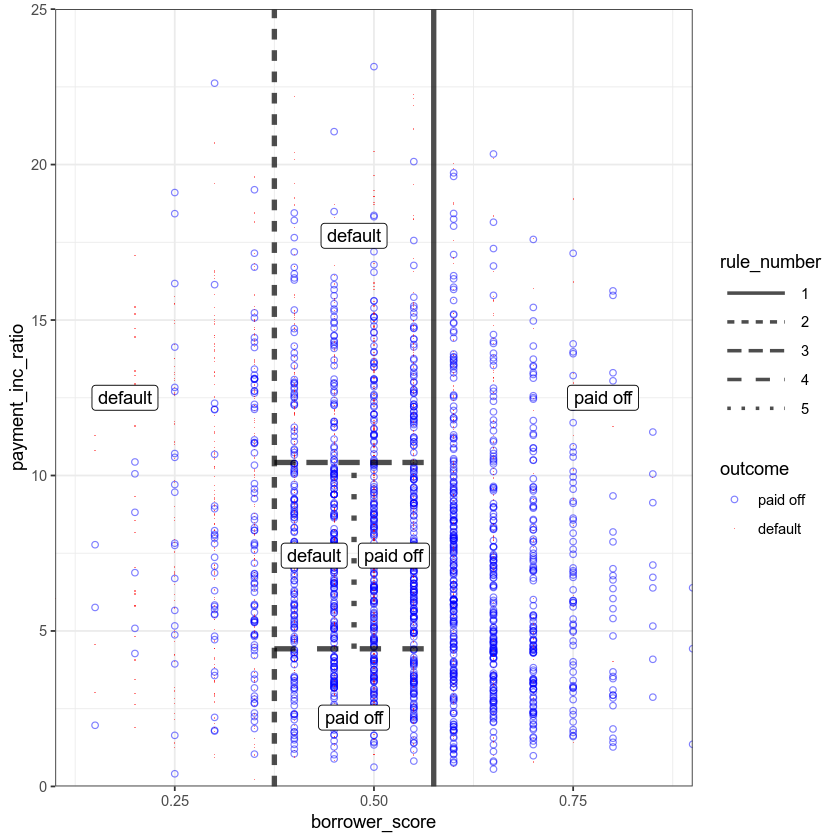

In [14]:
## Figure 6-4: View of partition rules
r_tree <- tibble(x1 = c(0.575, 0.375, 0.375, 0.375, 0.475),
                 x2 = c(0.575, 0.375, 0.575, 0.575, 0.475),
                 y1 = c(0,         0, 10.42, 4.426, 4.426),
                 y2 = c(25,       25, 10.42, 4.426, 10.42),
                 rule_number = factor(c(1, 2, 3, 4, 5)))
r_tree <- as.data.frame(r_tree)

rules <- tibble(x=c(0.575, 0.375, 0.4, 0.4, 0.475),
                y=c(24, 24, 10.42, 4.426, 9.42),
                rule_number = factor(c(1, 2, 3, 4, 5))) # , 3, 4, 5)))

labs <- tibble(x=c(.575 + (1-.575)/2, 
                   .375/2, 
                   (.375 + .575)/2,
                   (.375 + .575)/2, 
                   (.475 + .575)/2, 
                   (.375 + .475)/2
                   ),
               y=c(12.5, 
                   12.5,
                   10.42 + (25-10.42)/2,
                   4.426/2, 
                   4.426 + (10.42-4.426)/2,
                   4.426 + (10.42-4.426)/2
                   ),
               decision = factor(c('paid off', 'default', 'default', 'paid off', 'paid off', 'default')))

graph <- ggplot(data=loan3000, aes(x=borrower_score, y=payment_inc_ratio)) +
  geom_point( aes(color=outcome, shape=outcome), alpha=.5) +
  scale_color_manual(values=c('blue', 'red')) +
  scale_shape_manual(values = c(1, 46)) +
  geom_segment(data=r_tree, aes(x=x1, y=y1, xend=x2, yend=y2, linetype=rule_number), size=1.5, alpha=.7) +
  guides(color = guide_legend(override.aes = list(size=1.5)),
         linetype = guide_legend(keywidth=3, override.aes = list(size=1))) +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0)) + 
  coord_cartesian(ylim=c(0, 25)) +
  geom_label(data=labs, aes(x=x, y=y, label=decision)) +
  #theme(legend.position='bottom') +
  theme_bw()
graph

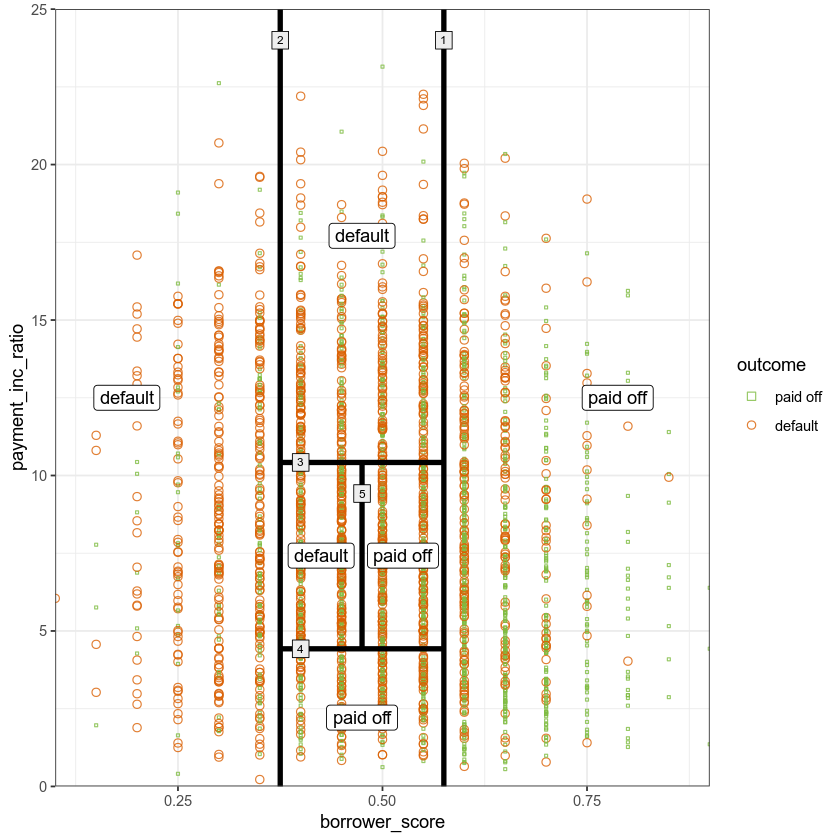

In [15]:
graph <- ggplot(data=loan3000, aes(x=borrower_score, y=payment_inc_ratio)) +
  geom_point( aes(color=outcome, shape=outcome, size=outcome), alpha=.8) +
  scale_color_manual(values = c("paid off"="#7fbc41", "default"="#d95f02")) +
  scale_shape_manual(values = c('paid off'=0, 'default'=1)) +
  scale_size_manual(values = c('paid off'=0.5, 'default'=2)) +
  geom_segment(data=r_tree, aes(x=x1, y=y1, xend=x2, yend=y2), size=1.5) + #, linetype=rule_number), size=1.5, alpha=.7) +
  guides(color = guide_legend(override.aes = list(size=1.5)),
         linetype = guide_legend(keywidth=3, override.aes = list(size=1))) +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0)) + 
  coord_cartesian(ylim=c(0, 25)) +
  geom_label(data=labs, aes(x=x, y=y, label=decision)) +
  geom_label(data=rules, aes(x=x, y=y, label=rule_number), 
             size=2.5,
             fill='#eeeeee', label.r=unit(0, "lines"), label.padding=unit(0.2, "lines")) +
  guides(color = guide_legend(override.aes = list(size=2))) +
  theme_bw()
graph

## Measuring Homogeneity or Impurity

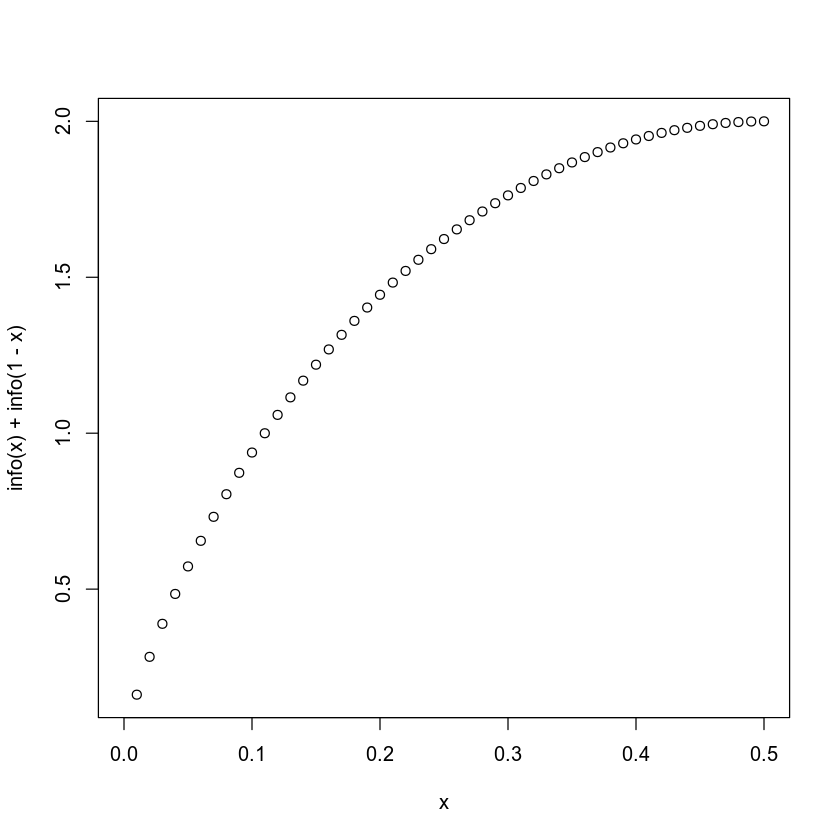

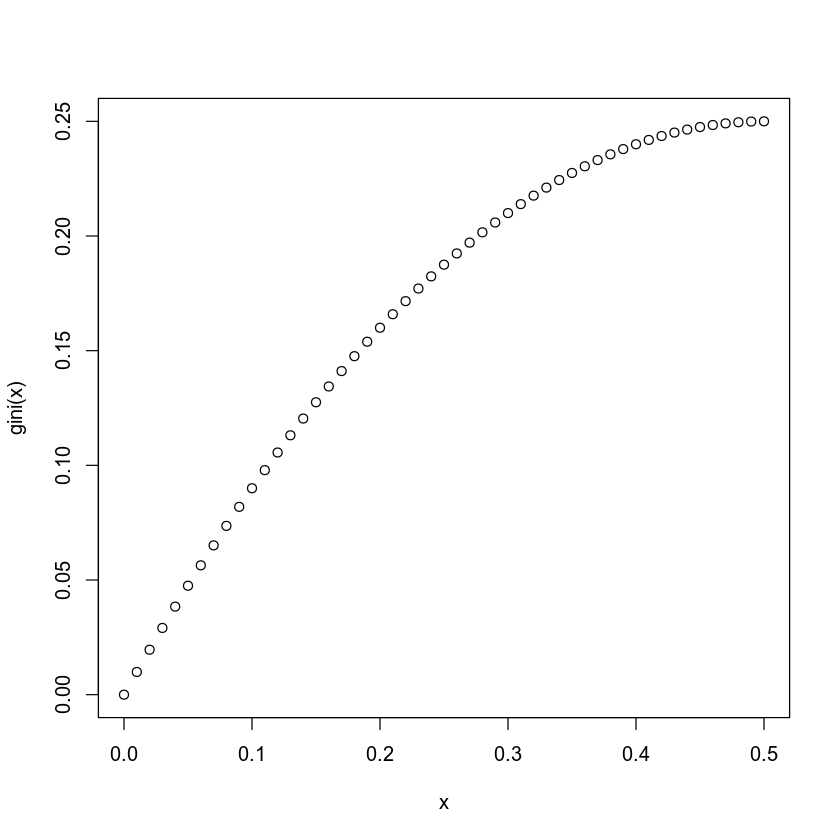

In [16]:
info <- function(x){
  info <- ifelse(x==0, 0, -x * log2(x) - (1-x) * log2(1-x))
  return(info)
}
x <- 0:50/100
plot(x, info(x) + info(1-x))

gini <- function(x){
  return(x * (1-x))
}
plot(x, gini(x))

In [17]:
impure <- data.frame(p = rep(x, 3),
                     impurity = c(2*x,
                                  gini(x)/gini(.5)*info(.5),
                                  info(x)),
                     type = rep(c('Accuracy', 'Gini', 'Entropy'), rep(51,3)))

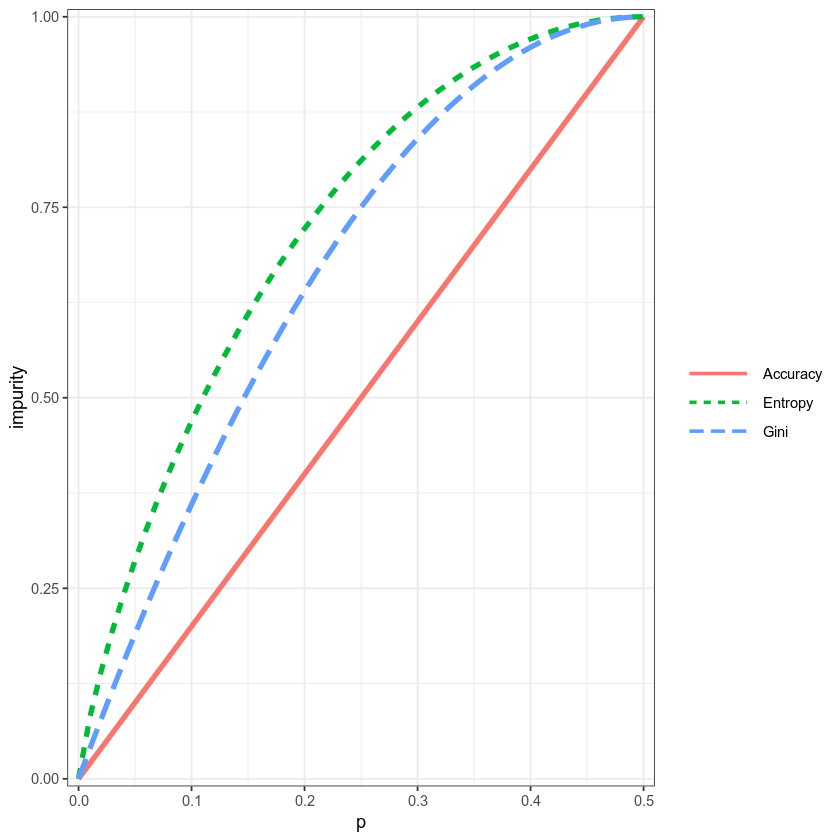

In [18]:
graph <- ggplot(data=impure, aes(x=p, y=impurity, linetype=type, color=type)) + 
  geom_line(size=1.5) +
  guides( linetype = guide_legend( keywidth=3, override.aes = list(size=1))) +
  scale_x_continuous(expand=c(0,0.01)) + 
  scale_y_continuous(expand=c(0,0.01)) + 
  theme_bw() +
  theme(legend.title=element_blank()) 
graph

# Bagging and the Random Forest
## Random Forest


In [19]:
rf <- randomForest(outcome ~ borrower_score + payment_inc_ratio,
                   data=loan3000)
rf


Call:
 randomForest(formula = outcome ~ borrower_score + payment_inc_ratio,      data = loan3000) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 39%
Confusion matrix:
         paid off default class.error
paid off      970     585   0.3762058
default       585     860   0.4048443

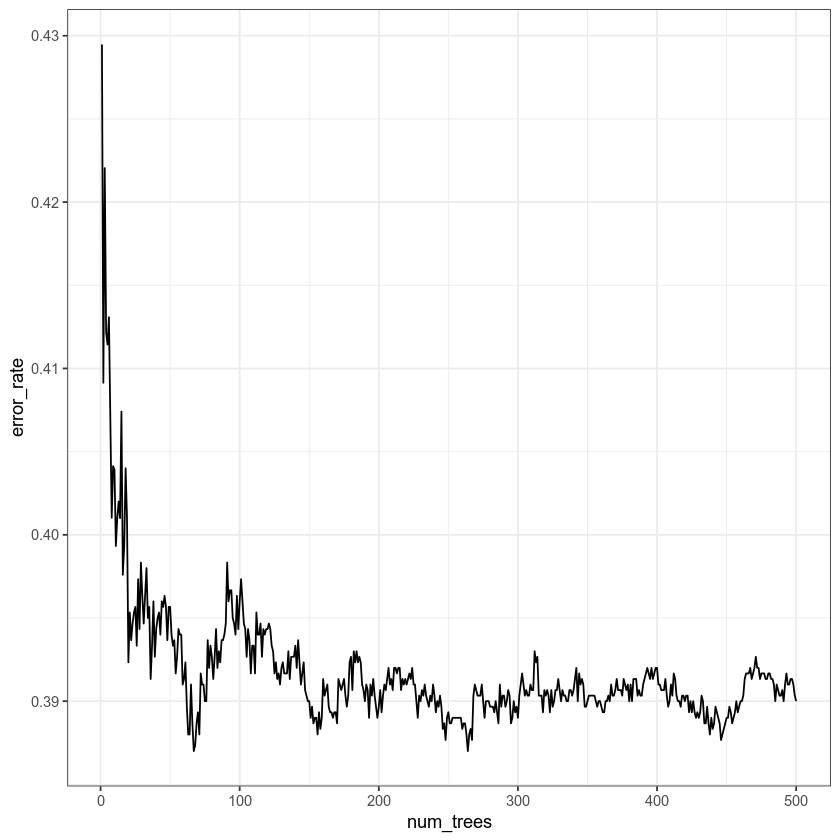

In [20]:
error_df = data.frame(error_rate=rf$err.rate[,'OOB'],
                      num_trees=1:rf$ntree)
graph <- ggplot(error_df, aes(x=num_trees, y=error_rate)) +
  geom_line()  +
  theme_bw()
graph

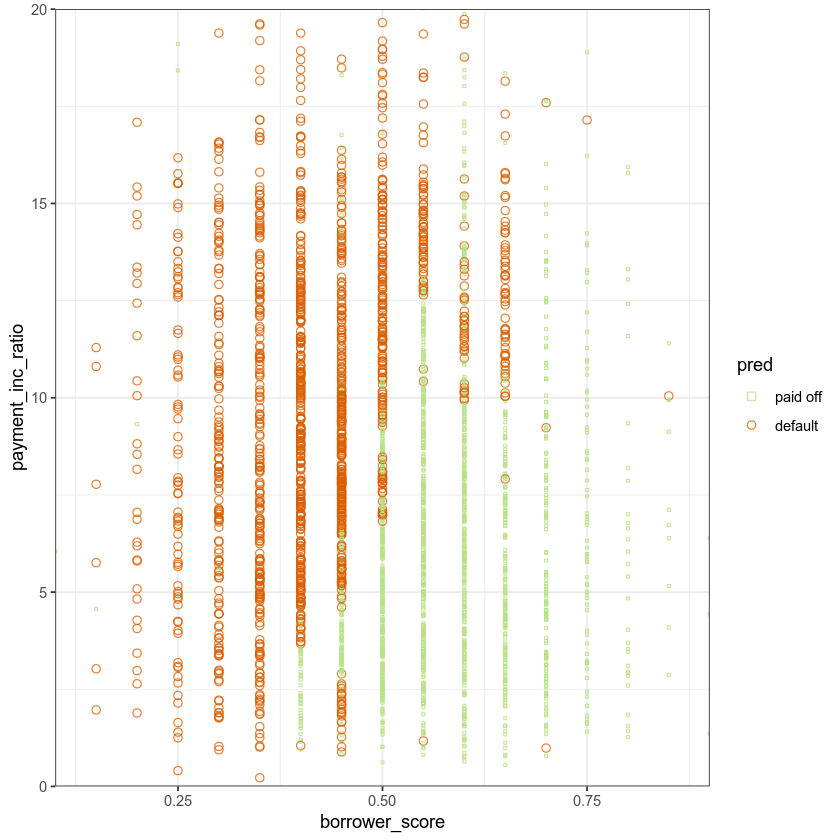

In [21]:
pred <- predict(rf, prob=TRUE)
rf_df <- cbind(loan3000, pred = pred)

graph <- ggplot(data=rf_df, aes(x=borrower_score, y=payment_inc_ratio, 
                       shape=pred, color=pred, size=pred)) +
  geom_point(alpha=.8) +
  scale_color_manual(values = c('paid off'='#b8e186', 'default'='#d95f02')) +
  scale_shape_manual(values = c('paid off'=0, 'default'=1)) +
  scale_size_manual(values = c('paid off'=0.5, 'default'=2)) +

  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0)) + 
  coord_cartesian(ylim=c(0, 20)) +
  guides(color = guide_legend(override.aes = list(size=2))) +
  theme_bw()
graph

A nice plot showing a gradient of predictions but not as illustrative as the prior plot (not in book)

In [22]:
# graph <- ggplot(data=rf_df, aes(x=borrower_score, y=payment_inc_ratio, color=prob_default)) +
#   geom_point(alpha=.6) +
#   scale_color_gradient2(low='blue', mid='white', high='red', midpoint=.5) +
#   scale_x_continuous(expand=c(0,0)) + 
#   scale_y_continuous(expand=c(0,0), lim=c(0, 20)) + 
#   theme(legend.position='bottom') +
#   geom_line(data=lda_df0, col='green', size=2, alpha=.8)
# graph

In [23]:
# graph
# dev.off()

## Variable importance


Call:
 randomForest(formula = outcome ~ ., data = loan_data, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 33.96%
Confusion matrix:
         paid off default class.error
paid off    14605    8066   0.3557849
default      7330   15341   0.3233205

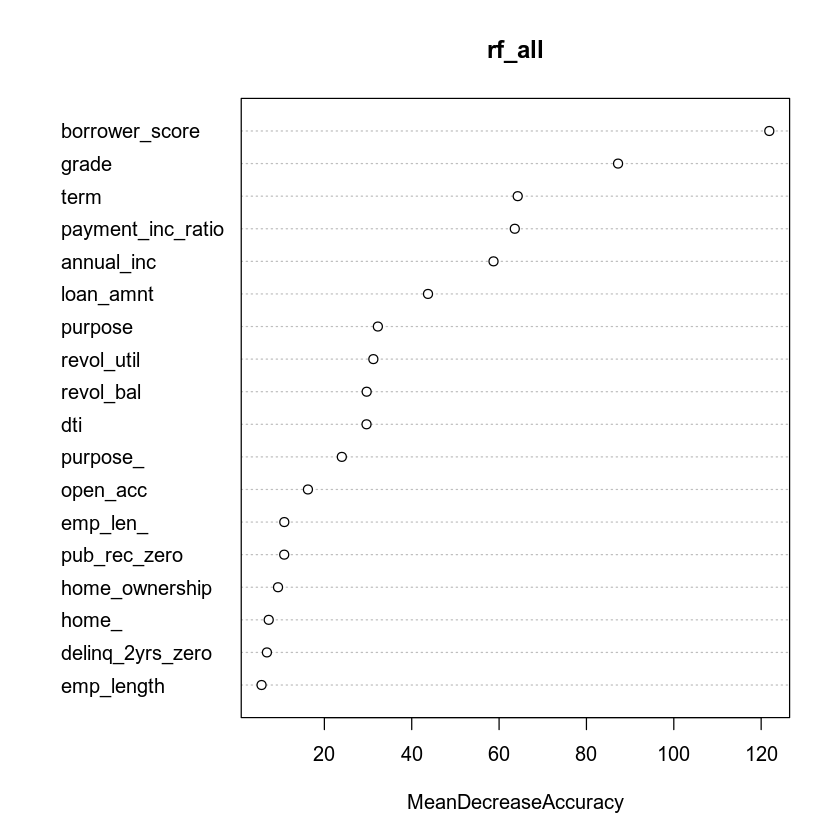

In [24]:
rf_all <- randomForest(outcome ~ ., data=loan_data, importance=TRUE)
rf_all

varImpPlot(rf_all, type=1)

imp1 <- importance(rf_all, type=1)
imp2 <- importance(rf_all, type=2)
idx <- order(imp1[,1])
nms <- factor(row.names(imp1)[idx], levels=row.names(imp1)[idx])
imp <- data.frame(Predictor = rep(nms, 2),
                  Importance = c(imp1[idx, 1], imp2[idx, 1]),
                  Type = rep( c('Accuracy Decrease', 'Gini Decrease'), rep(nrow(imp1), 2)))

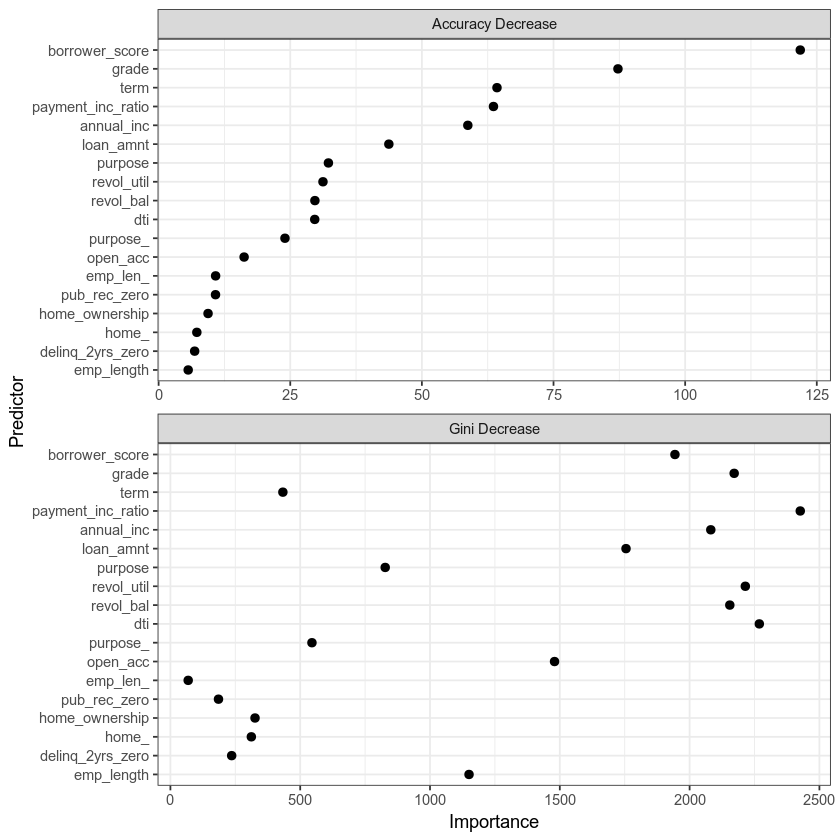

In [25]:
graph <- ggplot(imp) + 
  geom_point(aes(y=Predictor, x=Importance), size=2, stat="identity") + 
  facet_wrap(~Type, ncol=1, scales="free_x") + 
  theme(
    panel.grid.major.x = element_blank() ,
    panel.grid.major.y = element_line(linetype=3, color="darkgray") ) +
  theme_bw()
graph

## search over hyperparameter space (not in book); this takes a while

In [26]:
# loan_data1 <- loan_data0[,-which(names(loan_data0) %in% 'emp_length')]
# loan_data1$term = factor(loan_data1$term)
# loan_data1$emp_length = factor(loan_data1$emp_length>1)

# params <- data.frame(nodesize = c(5, 15, 25, 5, 10, 25),
#                      mtry = c(3, 3, 3, 5, 5, 5))
# rf_list <- vector('list', 6)
# for(i in 1:nrow(params)){
#   rf_list[[i]] <- randomForest(outcome ~ ., data=loan_data, mtry=params[i, 'mtry'],
#                                nodesize = params[i,'nodesize'], ntree=100)
# }

# rf_list[[1]]$confusion

# Boosting
## XGBoost

In [27]:
predictors <- data.matrix(loan3000[, c('borrower_score', 'payment_inc_ratio')])
label <- as.numeric(loan3000[,'outcome']) - 1
xgb <- xgboost(data=predictors, label=label, objective='binary:logistic', 
               params=list(subsample=0.63, eta=0.1), nrounds=100, 
               eval_metric='error')


pred <- predict(xgb, newdata=predictors)
xgb_df <- cbind(loan3000, pred_default = pred > 0.5, prob_default = pred)

[1]	train-error:0.359000 
[2]	train-error:0.351333 
[3]	train-error:0.347667 
[4]	train-error:0.339333 
[5]	train-error:0.339333 
[6]	train-error:0.337333 
[7]	train-error:0.335333 
[8]	train-error:0.334667 
[9]	train-error:0.337000 
[10]	train-error:0.332333 
[11]	train-error:0.324667 
[12]	train-error:0.326333 
[13]	train-error:0.318667 
[14]	train-error:0.320667 
[15]	train-error:0.320333 
[16]	train-error:0.320000 
[17]	train-error:0.318667 
[18]	train-error:0.317000 
[19]	train-error:0.313000 
[20]	train-error:0.308667 
[21]	train-error:0.307333 
[22]	train-error:0.307000 
[23]	train-error:0.312000 
[24]	train-error:0.312000 
[25]	train-error:0.308667 
[26]	train-error:0.308333 
[27]	train-error:0.308667 
[28]	train-error:0.307667 
[29]	train-error:0.303667 
[30]	train-error:0.300000 
[31]	train-error:0.299667 
[32]	train-error:0.295333 
[33]	train-error:0.296333 
[34]	train-error:0.295000 
[35]	train-error:0.294667 
[36]	train-error:0.295667 
[37]	train-error:0.292333 
[38]	train

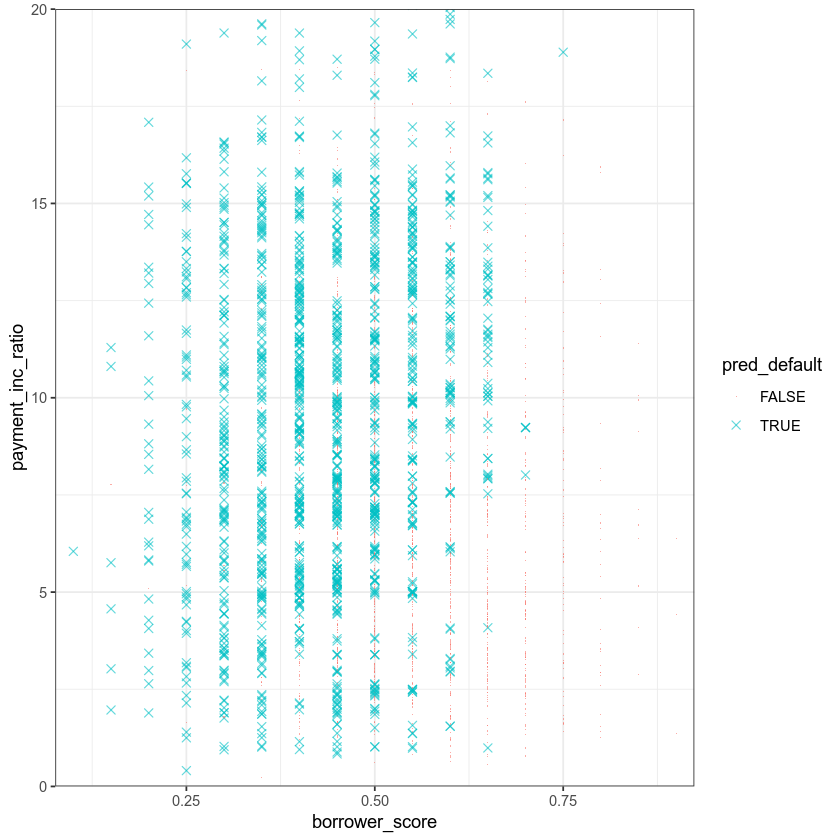

In [28]:
graph <- ggplot(data=xgb_df, aes(x=borrower_score, y=payment_inc_ratio, 
                        color=pred_default, shape=pred_default)) +
  geom_point(alpha=0.6, size=2) +
  scale_shape_manual( values=c(46, 4)) +
  scale_x_continuous(expand=c(0.03, 0)) + 
  scale_y_continuous(expand=c(0, 0)) + 
  coord_cartesian(ylim=c(0, 20)) +
  theme_bw()
graph

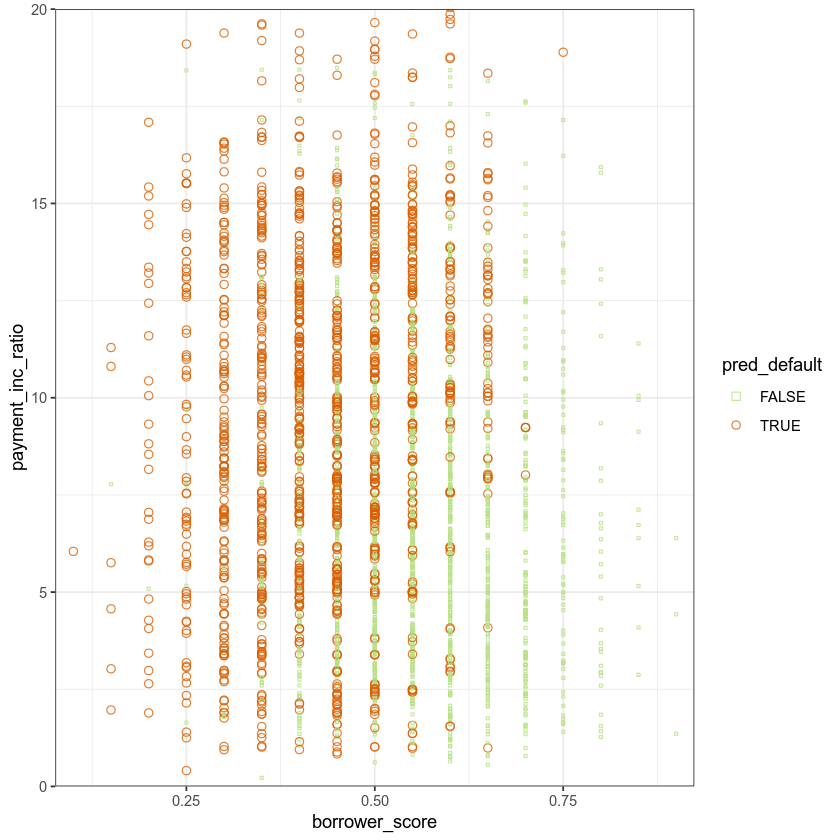

In [29]:
graph <- ggplot(data=xgb_df, aes(x=borrower_score, y=payment_inc_ratio, 
                color=pred_default, shape=pred_default, size=pred_default)) +
  geom_point(alpha=.8) +
  scale_color_manual(values = c('FALSE'='#b8e186', 'TRUE'='#d95f02')) +
  scale_shape_manual(values = c('FALSE'=0, 'TRUE'=1)) +
  scale_size_manual(values = c('FALSE'=0.5, 'TRUE'=2)) +

  scale_x_continuous(expand=c(0.03, 0)) + 
  scale_y_continuous(expand=c(0, 0)) + 
  coord_cartesian(ylim=c(0, 20)) +
  guides(color = guide_legend(override.aes = list(size=2))) +
  theme_bw()
graph

## Regularization: Avoiding Overfitting

In [30]:
seed <- 400820
predictors <- data.matrix(loan_data[,-which(names(loan_data) %in% 'outcome')])
label <- as.numeric(loan_data$outcome)-1
test_idx <- sample(nrow(loan_data), 10000)

xgb_default <- xgboost(data=predictors[-test_idx,], label=label[-test_idx], 
                       objective='binary:logistic', nrounds=250, verbose=0, 
                       eval_metric='error')
pred_default <- predict(xgb_default, predictors[test_idx,])
error_default <- abs(label[test_idx] - pred_default) > 0.5
xgb_default$evaluation_log[250,]
mean(error_default)

iter,train_error
<dbl>,<dbl>
250,0.1254881


[1] 0.3628

In [31]:
xgb_penalty <- xgboost(data=predictors[-test_idx,], label=label[-test_idx], 
                       params=list(eta=.1, subsample=.63, lambda=1000),
                       objective='binary:logistic', nrounds=250, verbose=0, 
                       eval_metric='error')
pred_penalty <- predict(xgb_penalty, predictors[test_idx,])
error_penalty <- abs(label[test_idx] - pred_penalty) > 0.5
xgb_penalty$evaluation_log[250,]
mean(error_penalty)

iter,train_error
<dbl>,<dbl>
250,0.3101126


[1] 0.3332

In [32]:
error_default <- rep(0, 250)
error_penalty <- rep(0, 250)
for(i in 1:250) {
  pred_default <- predict(xgb_default, predictors[test_idx,], iterationrange=c(1, i))
  error_default[i] <- mean(abs(label[test_idx] - pred_default) > 0.5)
  pred_penalty <- predict(xgb_penalty, predictors[test_idx,], iterationrange=c(1, i))
  error_penalty[i] <- mean(abs(label[test_idx] - pred_penalty) > 0.5)
}

errors <- rbind(xgb_default$evaluation_log,
                xgb_penalty$evaluation_log,
                data.frame(iter=1:250, train_error=error_default),
                data.frame(iter=1:250, train_error=error_penalty))
errors$type <- rep(c('default train', 'penalty train', 
                     'default test', 'penalty test'), rep(250, 4))

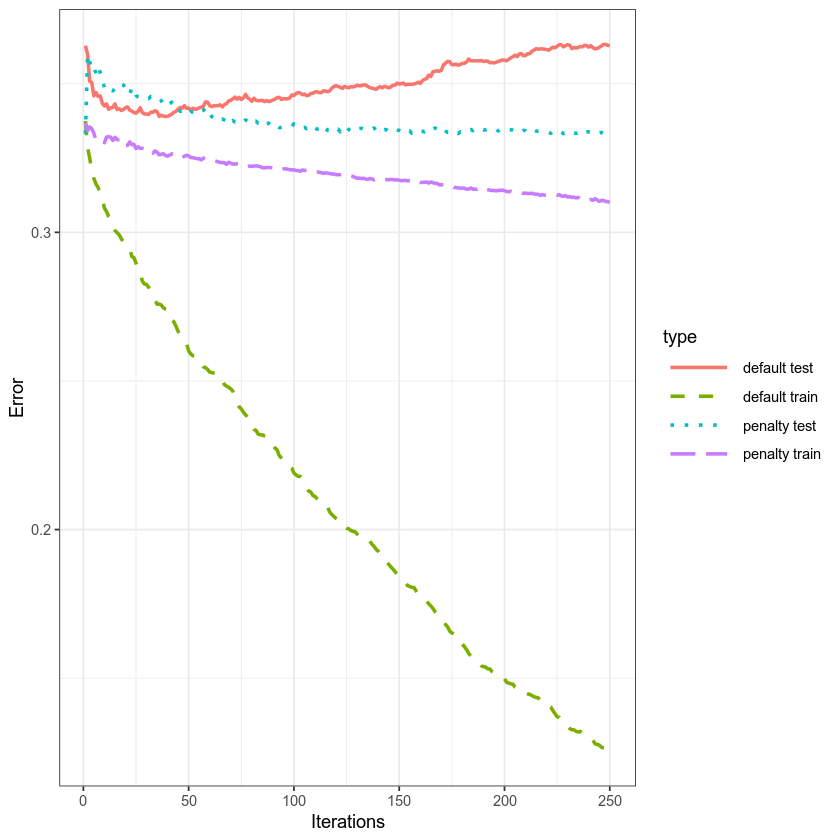

In [33]:
graph <- ggplot(errors, aes(x=iter, y=train_error, group=type)) +
  geom_line(aes(linetype=type, color=type), size=1) +
  scale_linetype_manual(values=c('solid', 'dashed', 'dotted', 'longdash')) +
  theme_bw() +
  theme(legend.key.width = unit(1.5,"cm")) +
  labs(x="Iterations", y="Error") +
  guides(color = guide_legend(override.aes = list(size=1)))
graph

## Hyperparameters and Cross-Validation

In [34]:
N <- nrow(loan_data)
fold_number <- sample(1:5, N, replace=TRUE)
params <- data.frame(eta = rep(c(.1, .5, .9), 3),
                     max_depth = rep(c(3, 6, 12), rep(3,3)))
rf_list <- vector('list', 9)
error <- matrix(0, nrow=9, ncol=5)
for(i in 1:nrow(params)){
  for(k in 1:5){
    cat('Fold', k, 'for model', i, '\n')
    fold_idx <- (1:N)[fold_number == k]
    xgb <- xgboost(data=predictors[-fold_idx,], label=label[-fold_idx], 
                   params=list(eta=params[i, 'eta'], 
                               max_depth=params[i, 'max_depth']),
                   objective='binary:logistic', nrounds=100, verbose=0, 
                   eval_metric='error')
    pred <- predict(xgb, predictors[fold_idx,])
    error[i, k] <- mean(abs(label[fold_idx] - pred) >= 0.5)
  }
}

avg_error <- 100 * round(rowMeans(error), 4)
cbind(params, avg_error)

Fold 1 for model 1 
Fold 2 for model 1 
Fold 3 for model 1 
Fold 4 for model 1 
Fold 5 for model 1 
Fold 1 for model 2 
Fold 2 for model 2 
Fold 3 for model 2 
Fold 4 for model 2 
Fold 5 for model 2 
Fold 1 for model 3 
Fold 2 for model 3 
Fold 3 for model 3 
Fold 4 for model 3 
Fold 5 for model 3 
Fold 1 for model 4 
Fold 2 for model 4 
Fold 3 for model 4 
Fold 4 for model 4 
Fold 5 for model 4 
Fold 1 for model 5 
Fold 2 for model 5 
Fold 3 for model 5 
Fold 4 for model 5 
Fold 5 for model 5 
Fold 1 for model 6 
Fold 2 for model 6 
Fold 3 for model 6 
Fold 4 for model 6 
Fold 5 for model 6 
Fold 1 for model 7 
Fold 2 for model 7 
Fold 3 for model 7 
Fold 4 for model 7 
Fold 5 for model 7 
Fold 1 for model 8 
Fold 2 for model 8 
Fold 3 for model 8 
Fold 4 for model 8 
Fold 5 for model 8 
Fold 1 for model 9 
Fold 2 for model 9 
Fold 3 for model 9 
Fold 4 for model 9 
Fold 5 for model 9 


eta,max_depth,avg_error
<dbl>,<dbl>,<dbl>
0.1,3,33.04
0.5,3,33.47
0.9,3,34.41
0.1,6,33.13
0.5,6,35.45
0.9,6,37.57
0.1,12,34.65
0.5,12,36.89
0.9,12,38.19
